# Make final figures
Makes final versions of figures.

## Import Python packages

In [1]:
import os
import re
import xml.etree.ElementTree as ElementTree

from dms_tools2.ipython_utils import showPDF

import cairosvg

from IPython.display import display, Image, SVG

import matplotlib.image

import svgutils

import yaml

## Define some functions

In [2]:
def svg_dim(svgfile, dim):
    """Get width or height `dim` of `svgfile` in points."""
    return float(ElementTree.parse(svgfile).getroot().attrib[dim].replace('px', ''))

In [3]:
def svg_to_pdf(svgfile):
    """`svgfile` to PDF, return converted file name."""
    with open(svgfile) as f:
        svg = f.read()
    # need to eliminate units that `svgutils` incorrectly puts in viewBox
    viewbox_match = re.compile('viewBox="' + ' '.join(['\d+\.{0,1}\d*(px){0,1}'] * 4) + '"')
    if len(viewbox_match.findall(svg)) != 1:
        raise ValueError(f"did not find exactly one viewBox in {svgfile}")
    viewbox = viewbox_match.search(svg).group(0)
    svg = svg.replace(viewbox, viewbox.replace('px', ''))
    outfile = os.path.splitext(svgfile)[0] + '.pdf'
    cairosvg.svg2pdf(bytestring=svg, write_to=outfile)
    return outfile

In [4]:
def png_aspect(pngfile):
    """Aspect ratio (width to height) of `pngfile`."""
    shape = matplotlib.image.imread(pngfile).shape
    return shape[1] / shape[0]

## Read configuration

In [5]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)
    
with open(config['figure_config']) as f:
    figure_config = yaml.safe_load(f)
    
os.makedirs(config['finalfigsdir'], exist_ok=True)
print(f"Final figures go in {config['finalfigsdir']}")

Final figures go in results/figures/final


## Make combined logo / neut / struct plots

First for **non**-antibody samples:


Writing figure for VIDD_sera to results/figures/final/VIDD_sera.pdf


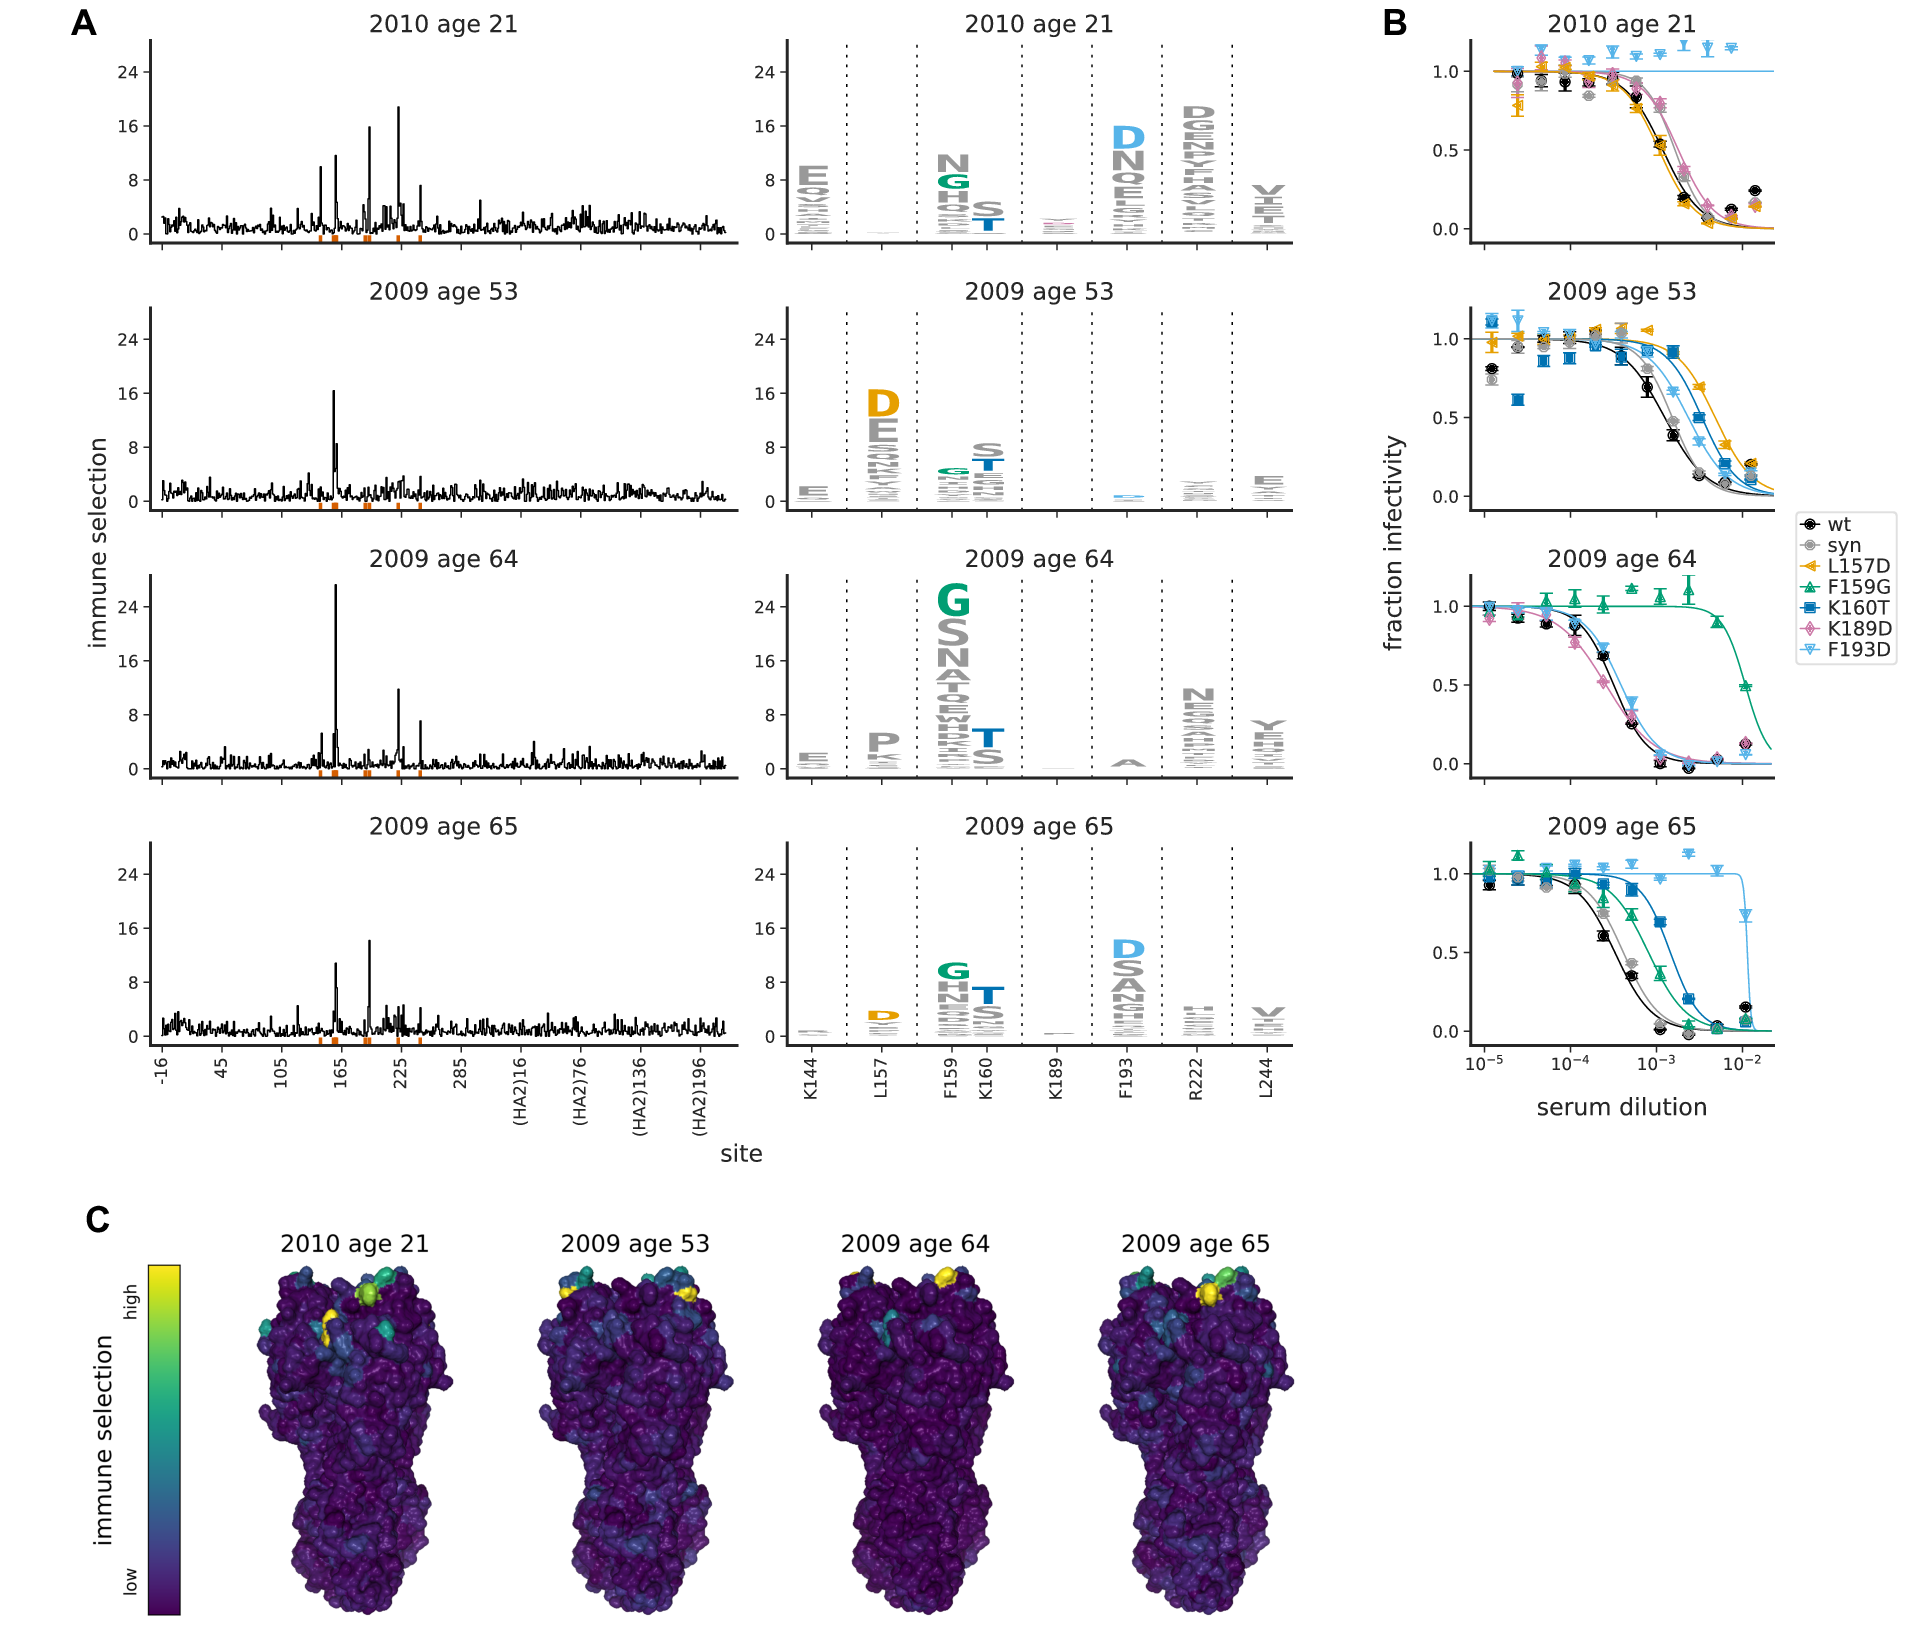


Writing figure for 2009_age_53_samples to results/figures/final/2009_age_53_samples.pdf


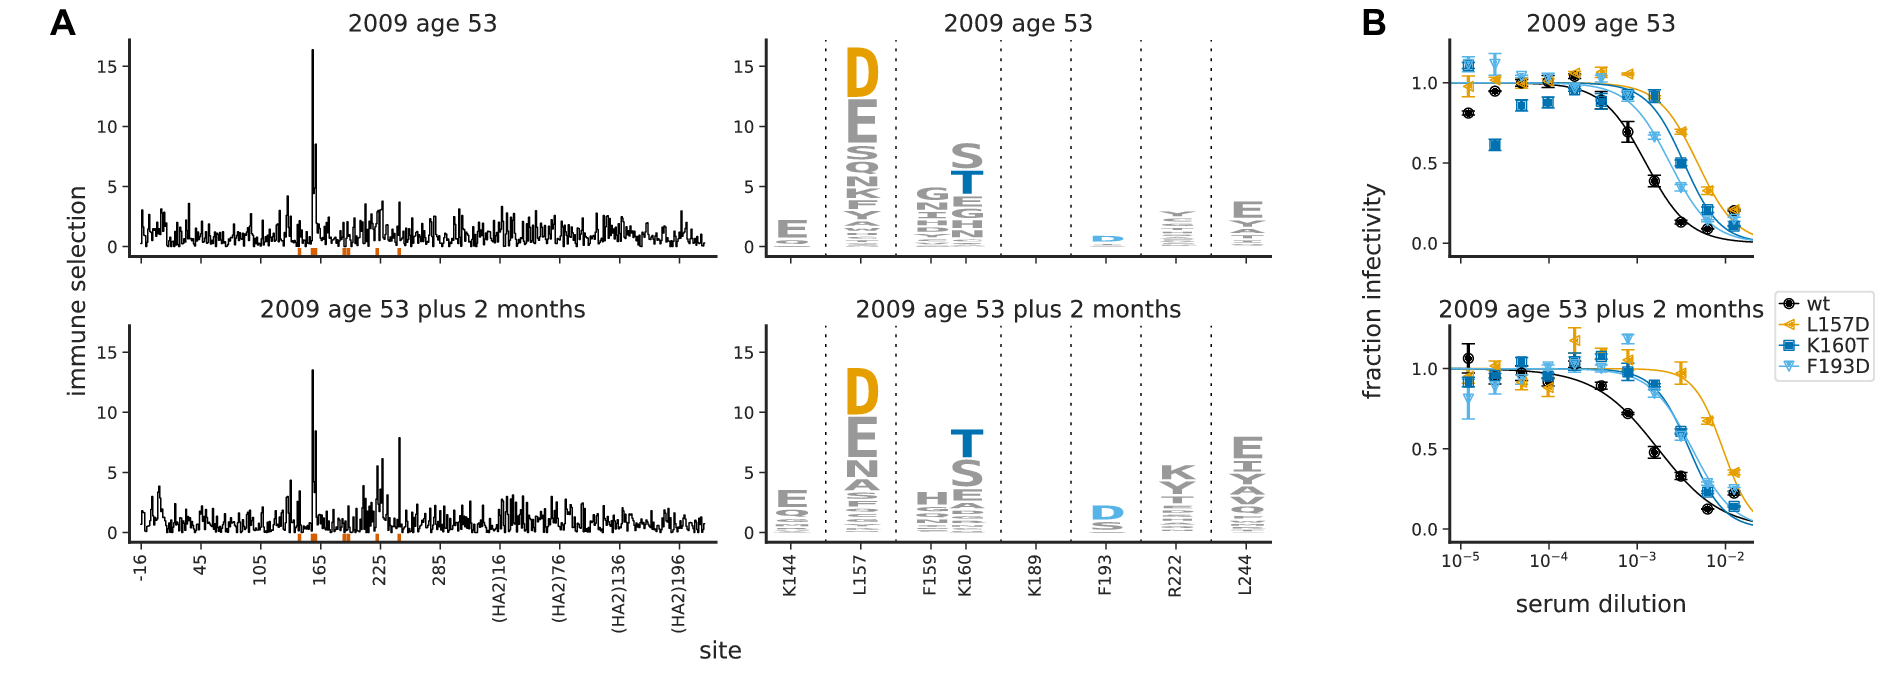


Writing figure for Hensley_sera to results/figures/final/Hensley_sera.pdf


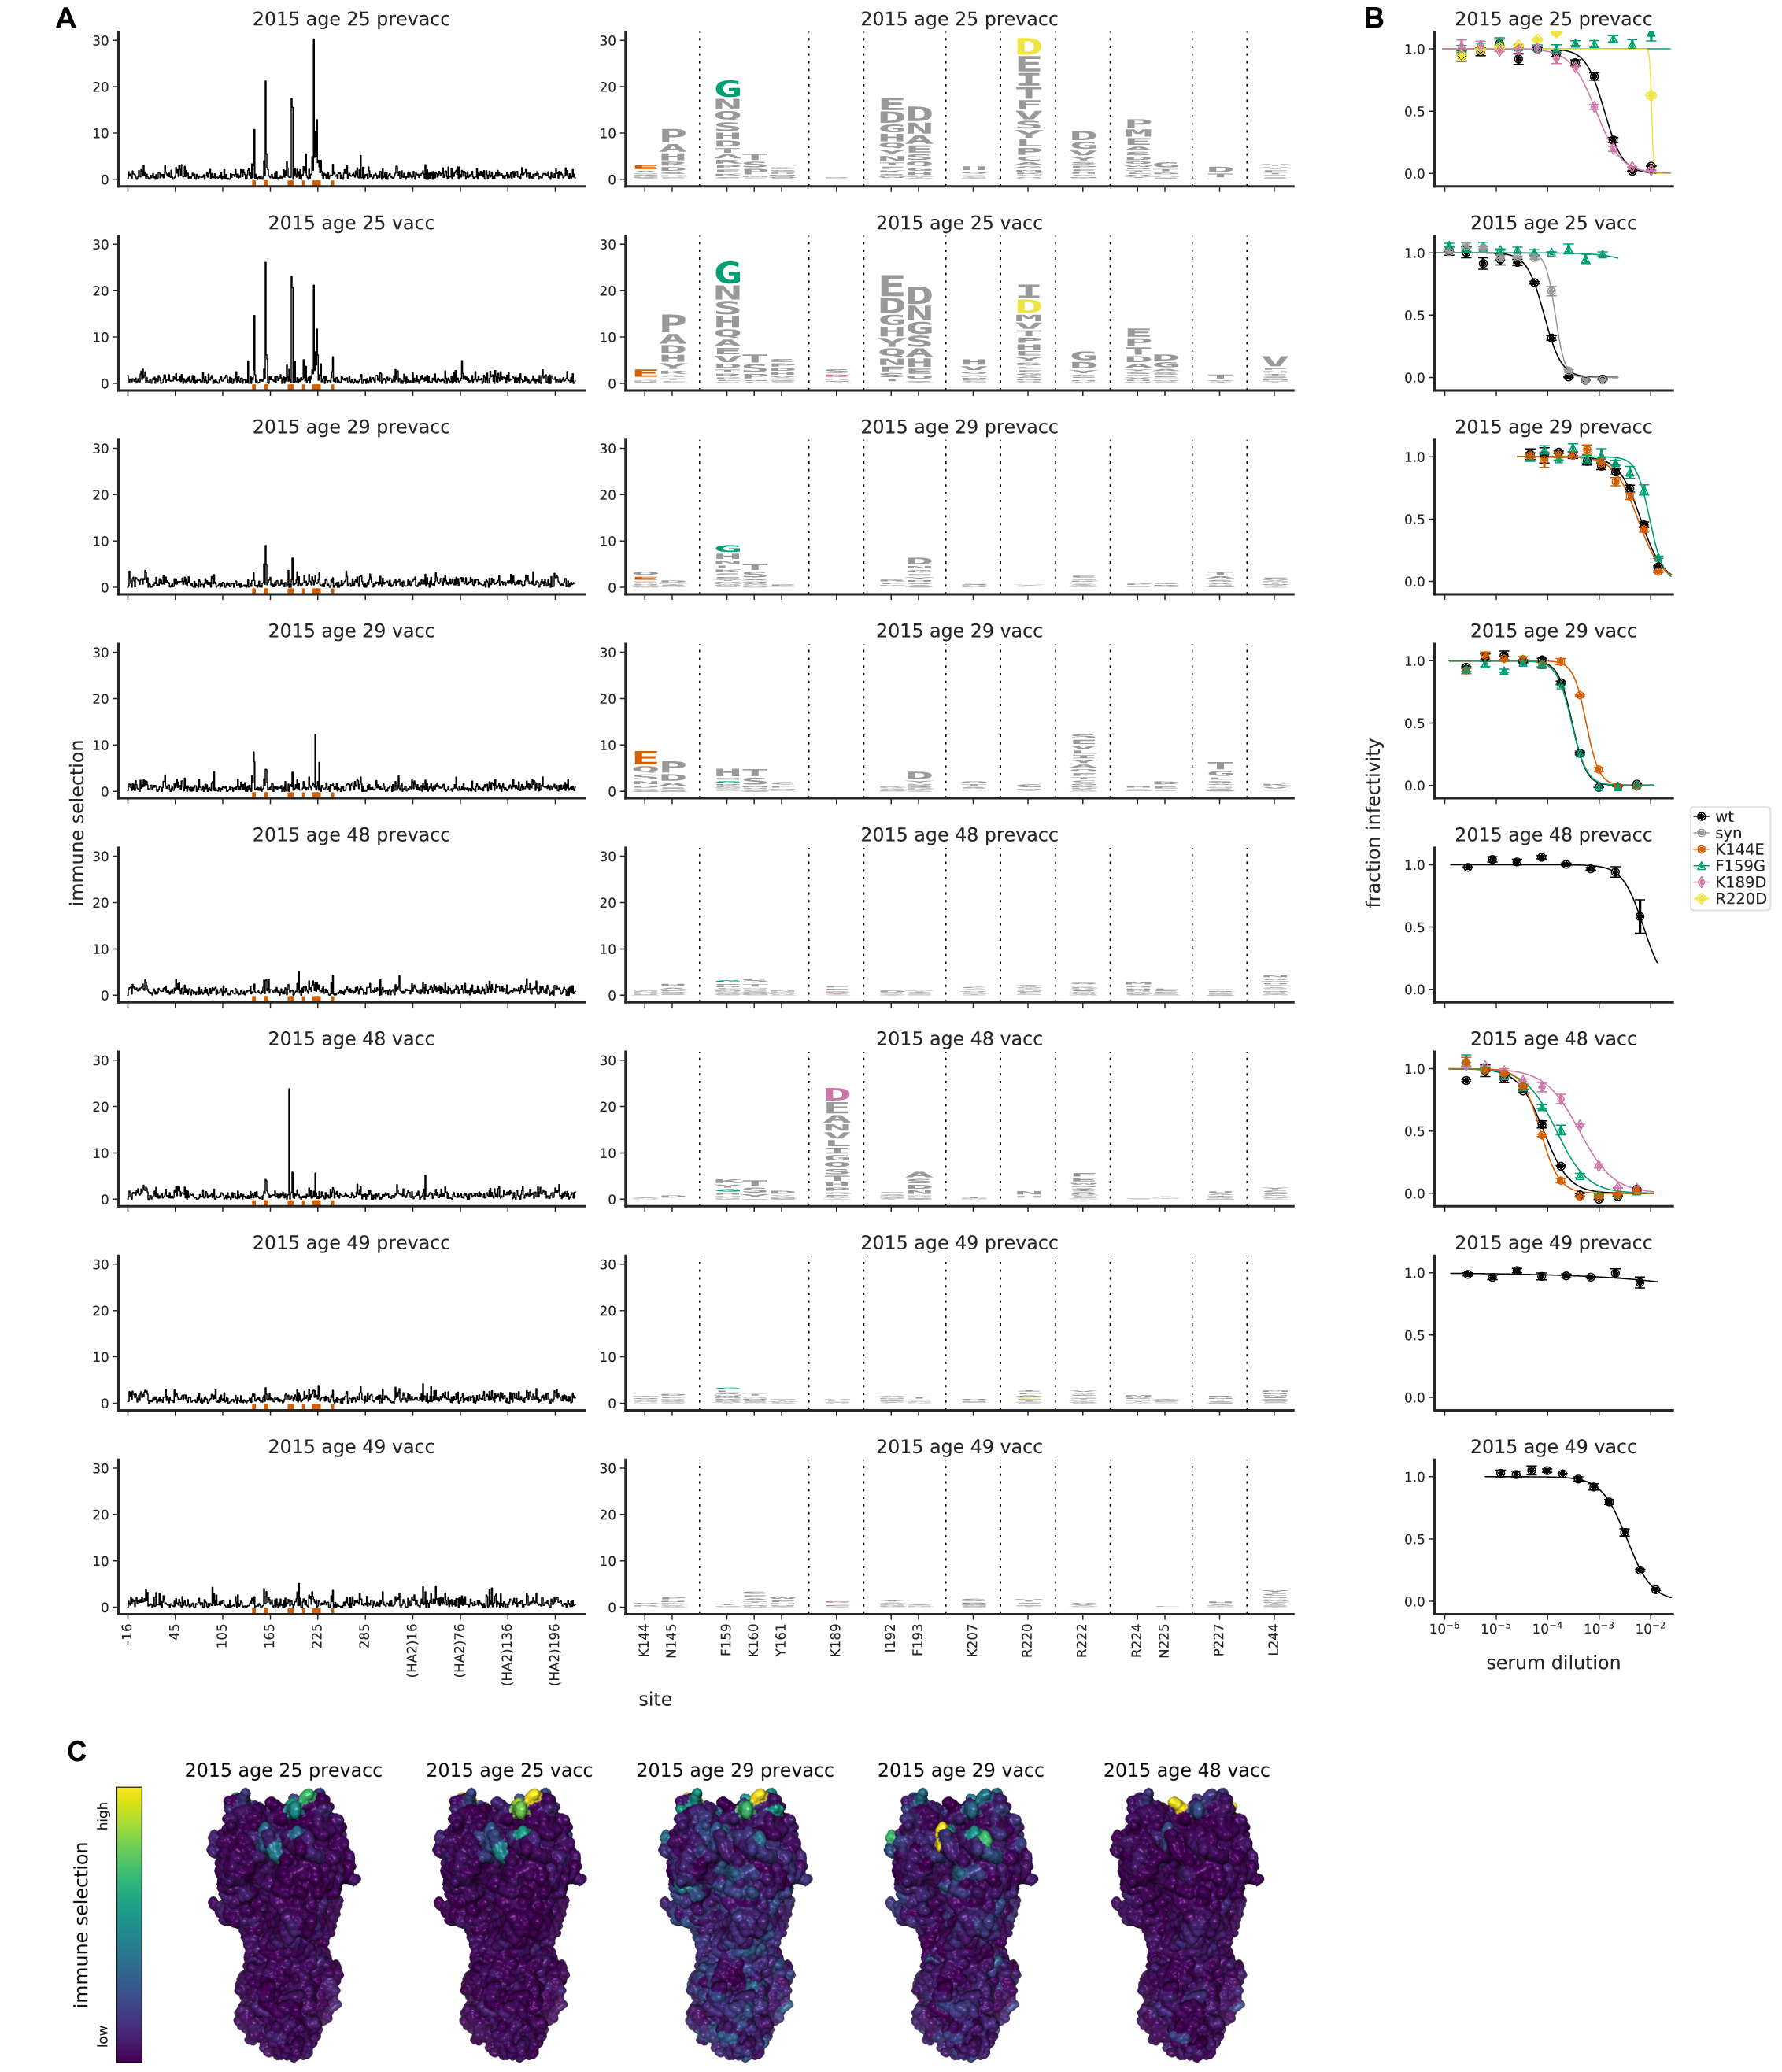


Writing figure for ferret to results/figures/final/ferret.pdf


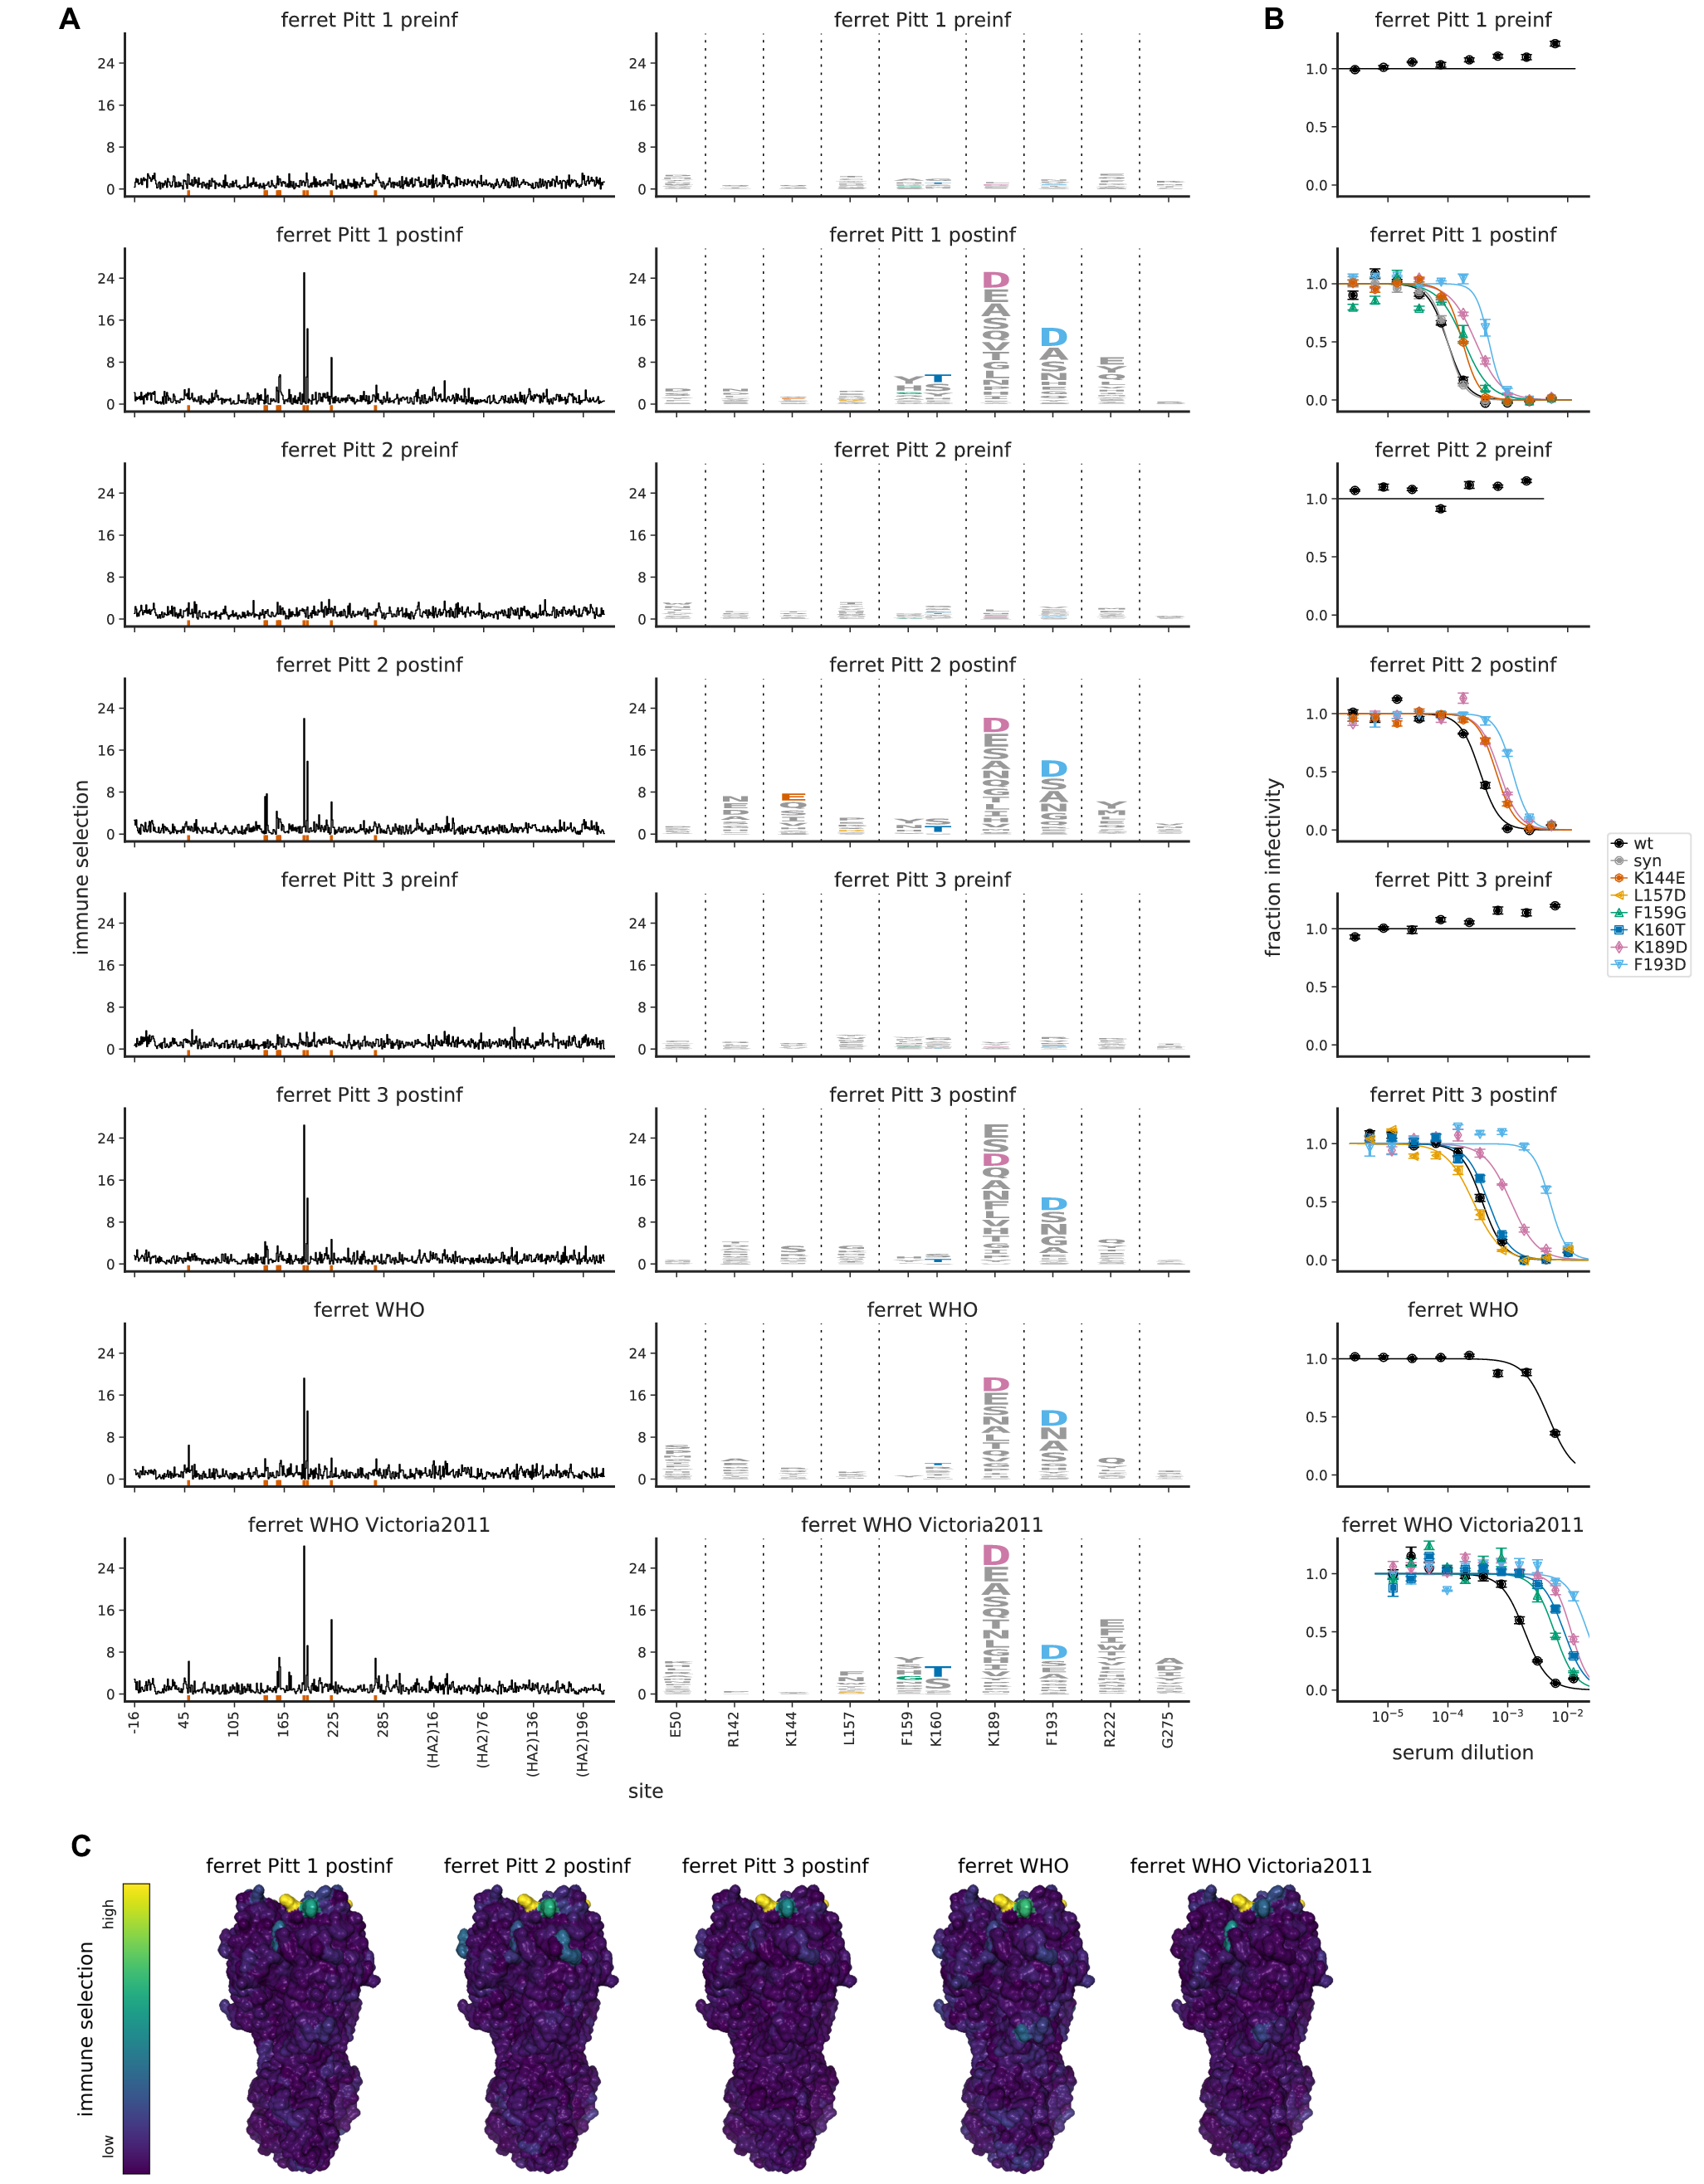


Writing figure for antibody_spikein to results/figures/final/antibody_spikein.pdf


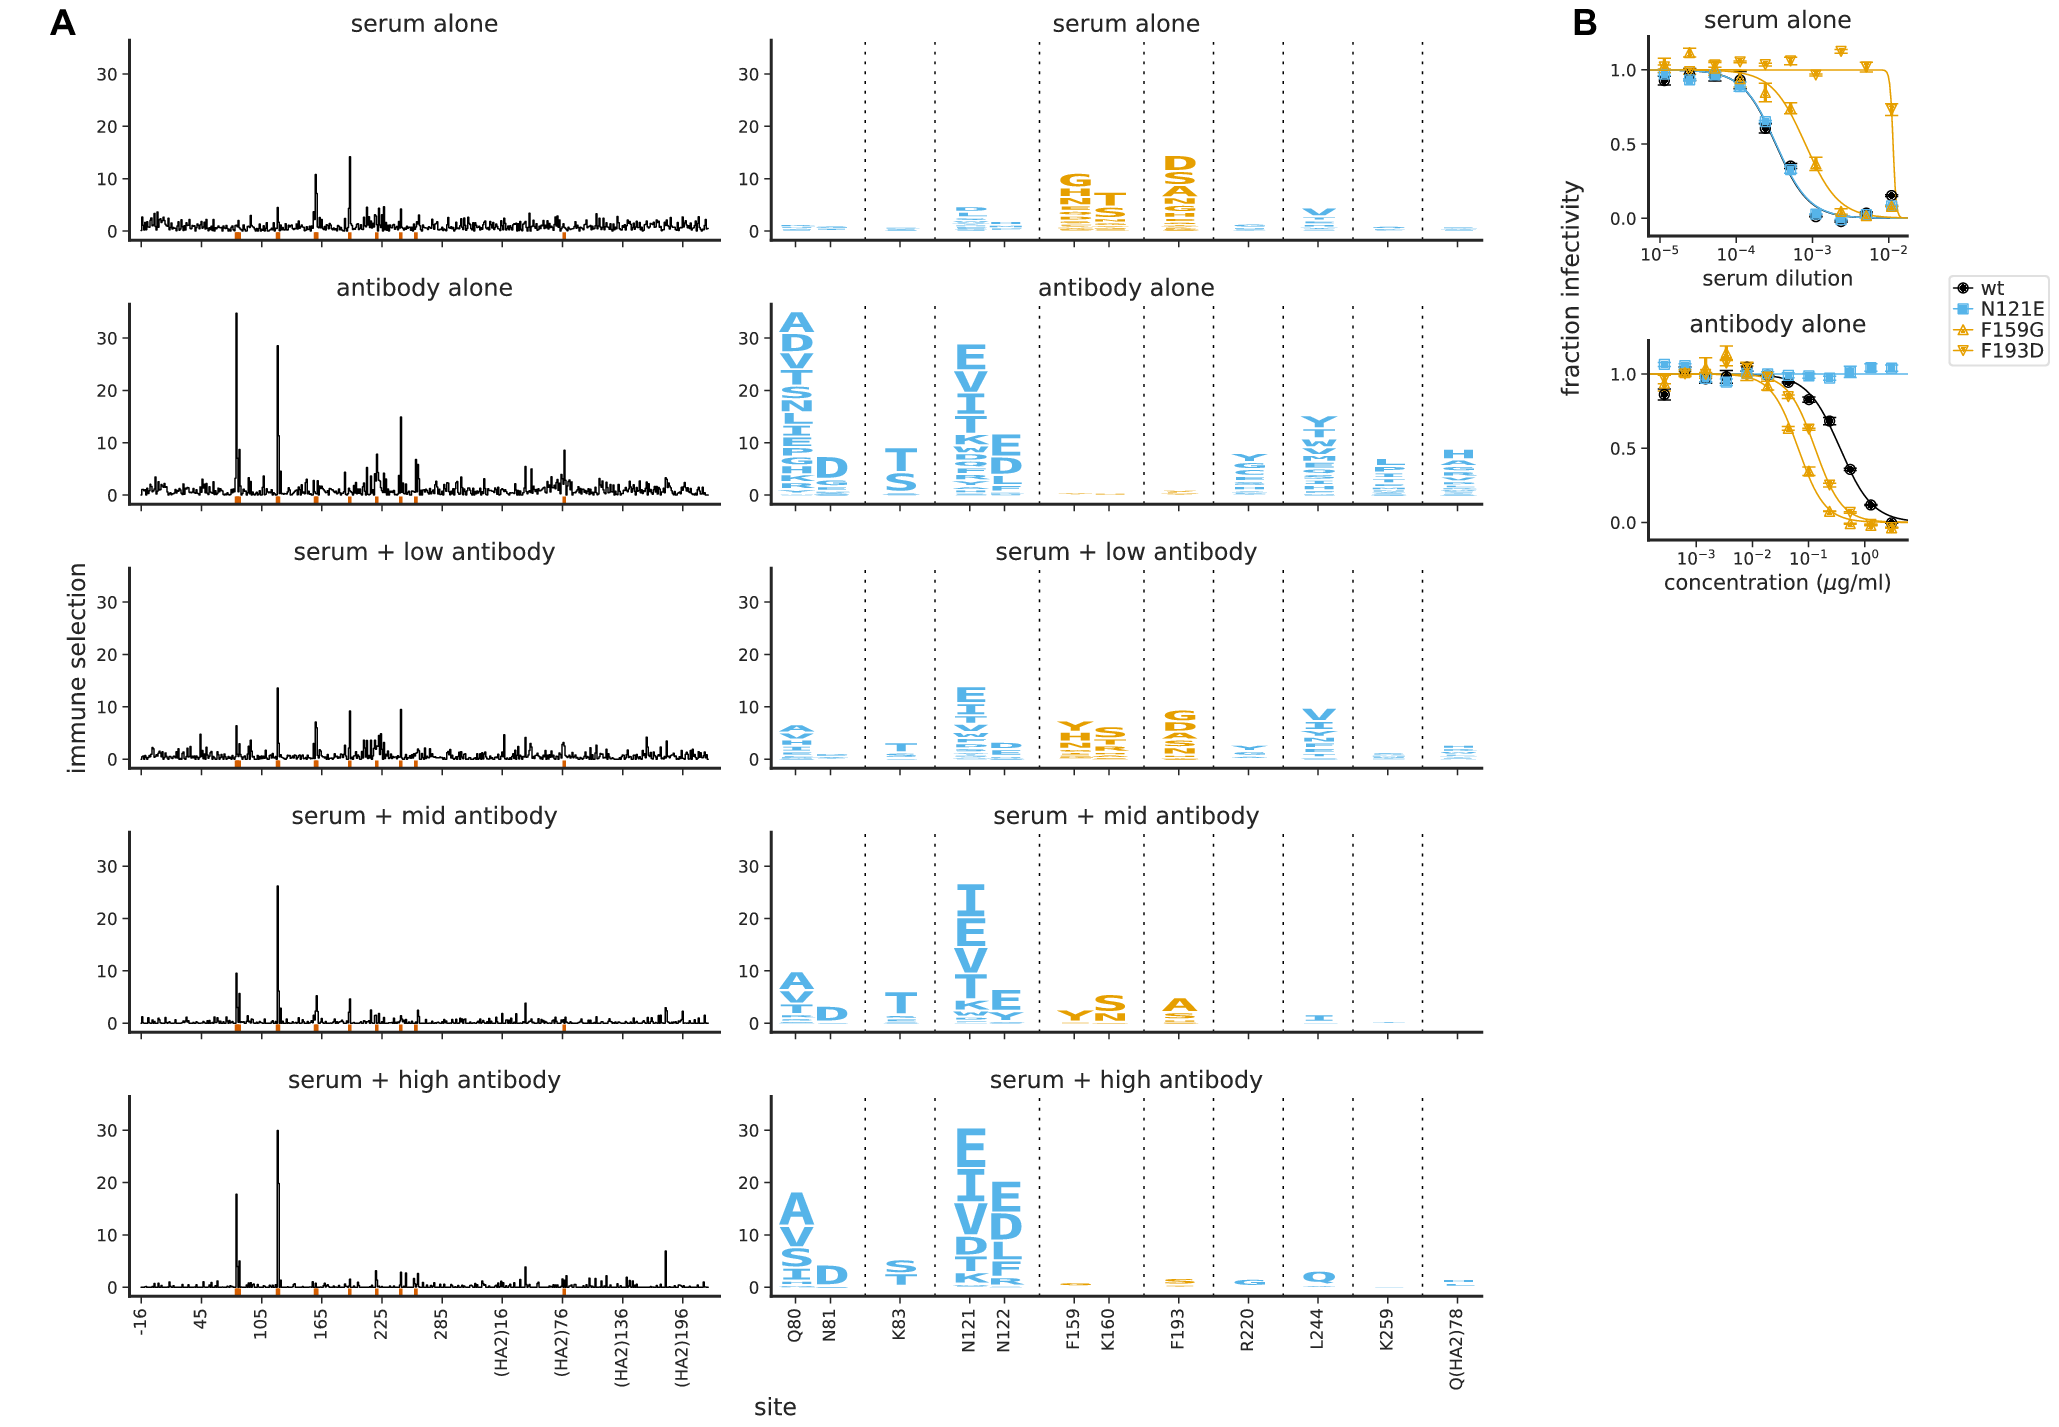

In [6]:
vmargin = 35  # vertical space between panels
struct_relheight = figure_config['struct_panel_height']

for fig, figconfig in figure_config['figures'].items():
    
    if fig in {'antibody_region_B', 'antibody_lower_head'}:
        continue
    
    logo_and_neut_svg = os.path.join(config['figsdir'], f"{fig}_logo_and_neut.svg")
    width = svg_dim(logo_and_neut_svg, 'width')
    height = svg_dim(logo_and_neut_svg, 'height')
    
    # a relative height for logo_and_neut
    logo_and_neut_relheight = 2.5 * len(figconfig['sera']) + 0.4 + 1.3
    
    fig_elements = [svgutils.compose.SVG(logo_and_neut_svg)]
    if 'sera_for_struct' in figconfig and len(figconfig['sera_for_struct']) > 0:
        struct_png = os.path.join(config['figsdir'], f"{fig}_struct.png")
        png_height = height * struct_relheight / logo_and_neut_relheight
        height += png_height + vmargin
        fig_elements.append(svgutils.compose.Image(
                        png_aspect(struct_png) * png_height,
                        png_height,
                        struct_png).move(10, height - png_height))
        fig_elements.append(svgutils.compose.Text(figconfig['struct_panel_label'],
                                                  15, 5, weight='bold', size='26',
                                                  font='Arial').move(10, height - png_height))
    f = svgutils.compose.Figure(width, height, *fig_elements)
    svg = os.path.join(config['finalfigsdir'], f"{fig}.svg")
    f.save(svg)
    pdf = svg_to_pdf(svg)
    print(f"\nWriting figure for {fig} to {pdf}")
    showPDF(pdf)

Now for antibody samples, combined into one figure:


Writing figure for antibodies to results/figures/final/antibodies.pdf


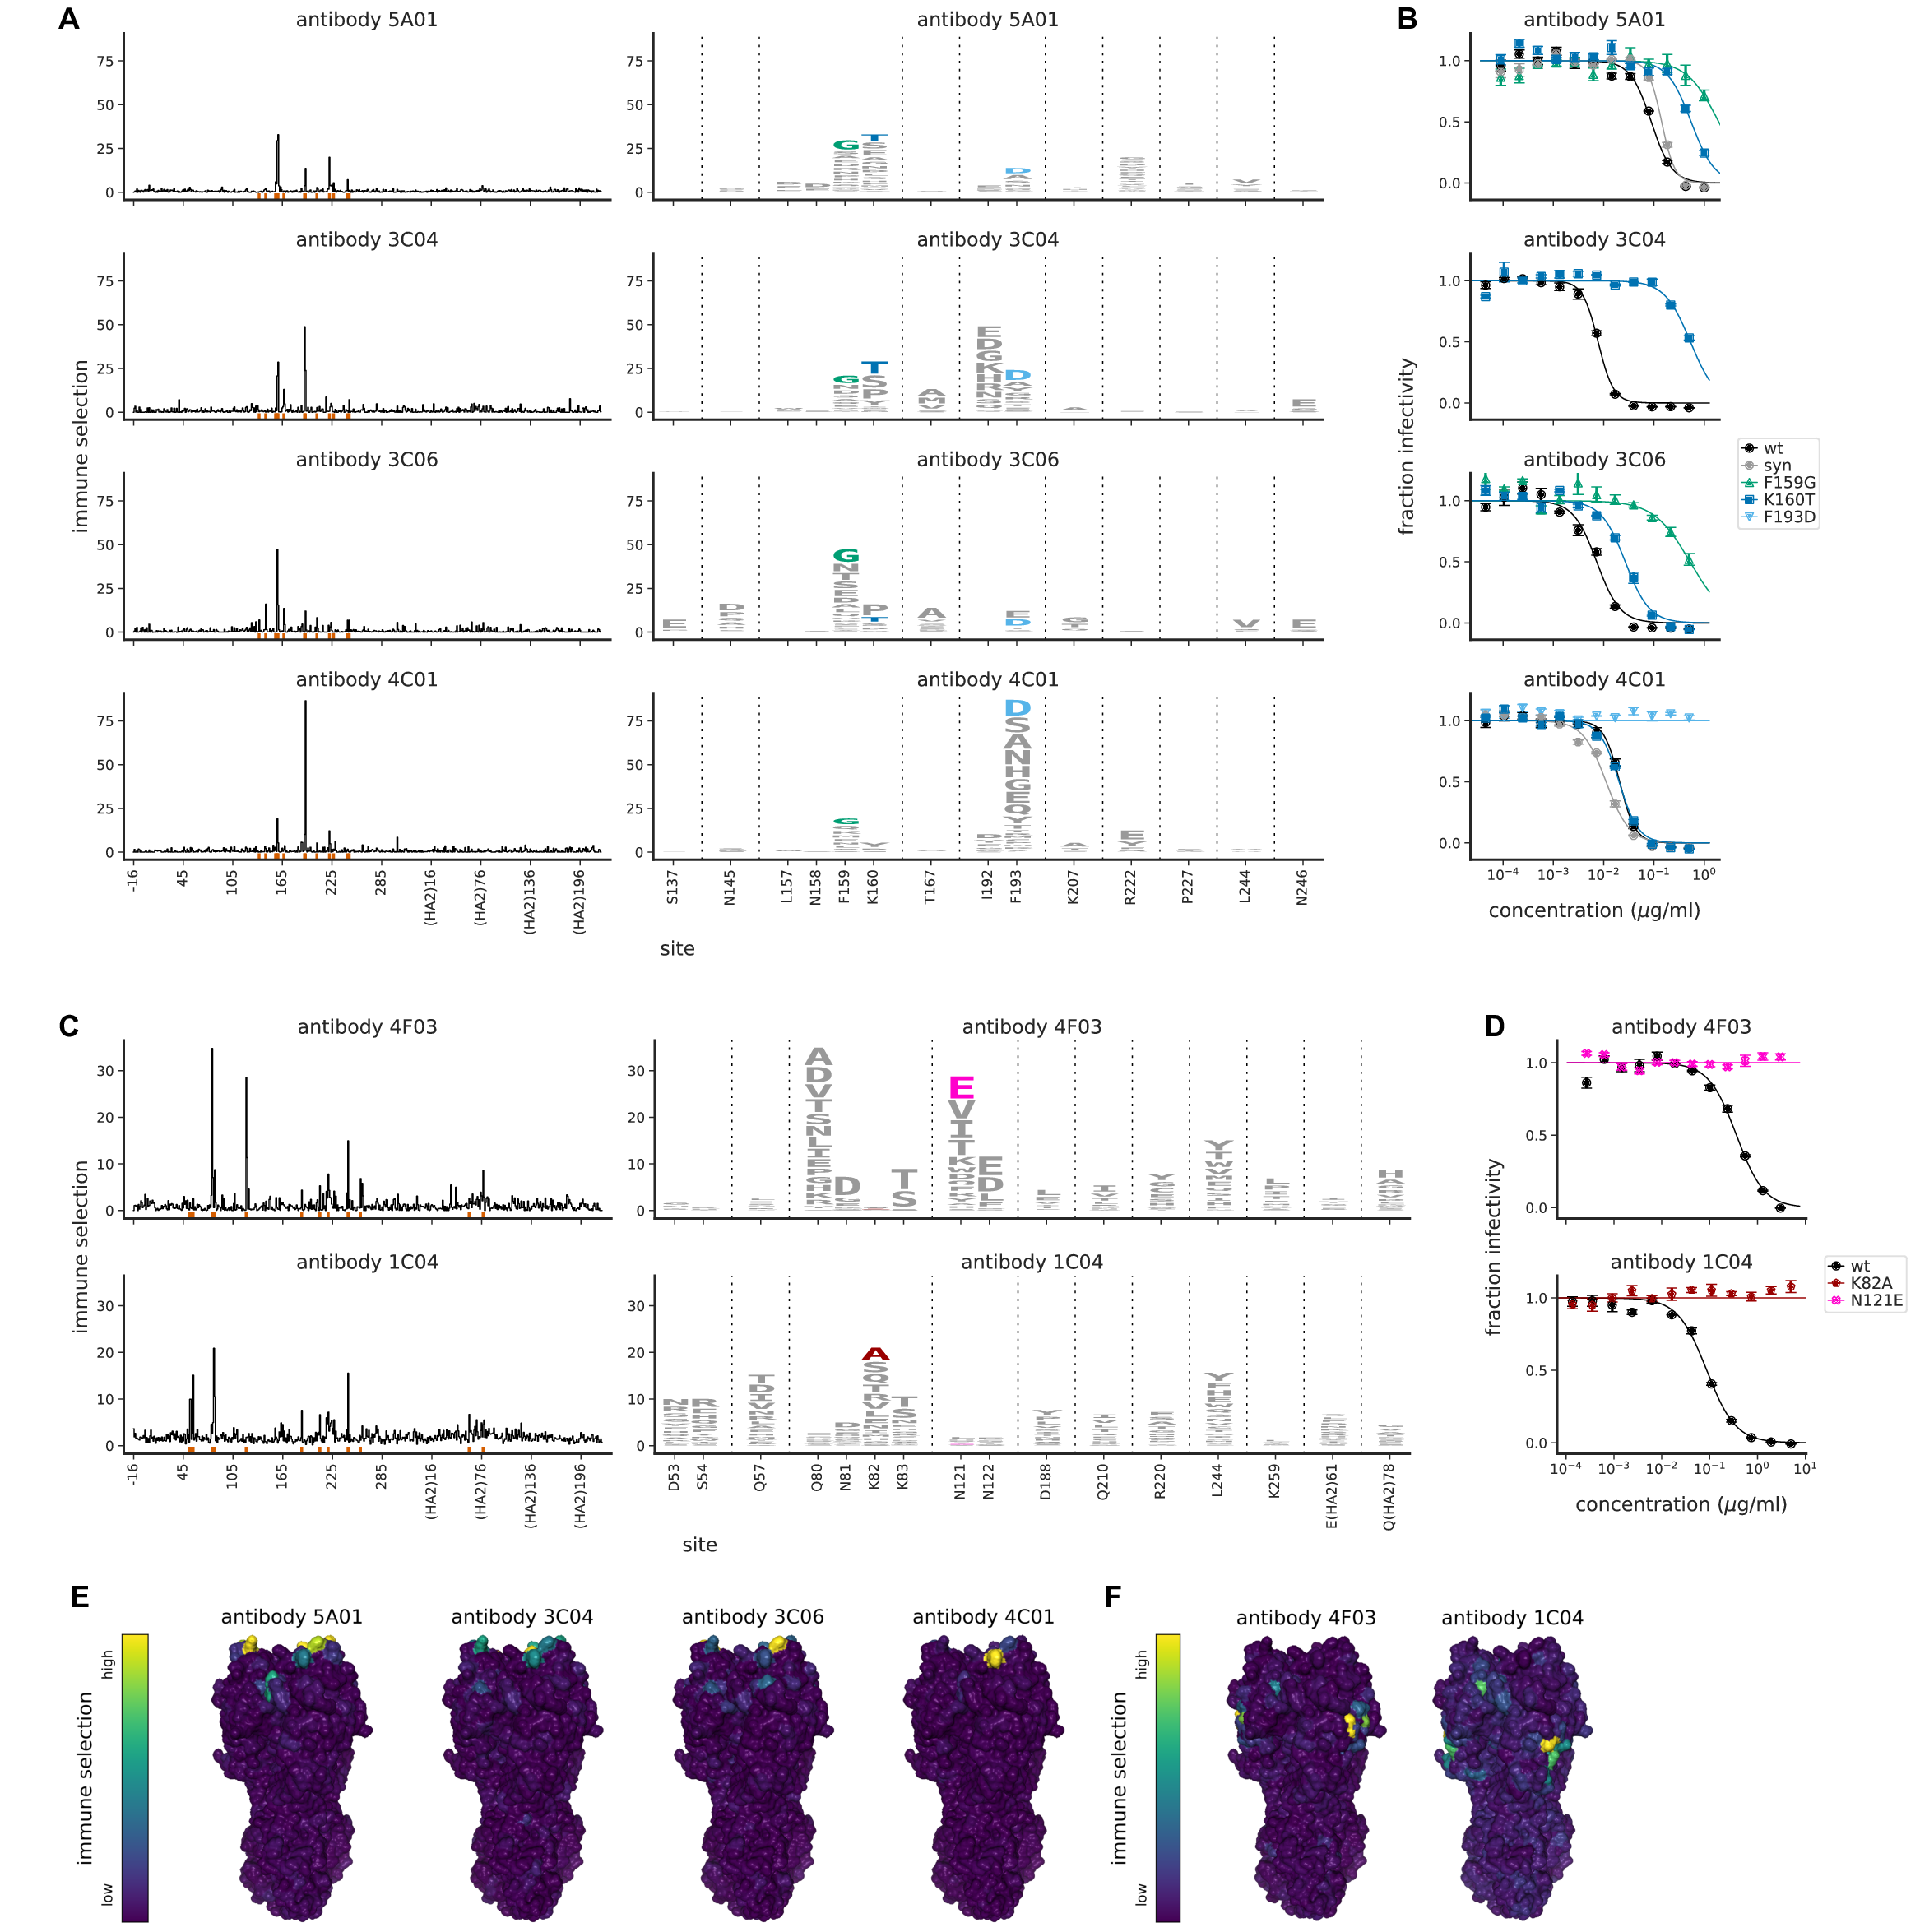

In [7]:
fig_elements = []
height = 0

antibodies = ['antibody_region_B', 'antibody_lower_head']
width = max(svg_dim(os.path.join(config['figsdir'], f"{fig}_logo_and_neut.svg"), 'width')
            for fig in antibodies)

for fig in antibodies:
    figconfig = figure_config['figures'][fig]
    logo_and_neut_svg = os.path.join(config['figsdir'], f"{fig}_logo_and_neut.svg")
    svg_height = svg_dim(logo_and_neut_svg, 'height')
    logo_and_neut_relheight = 2.5 * len(figconfig['sera']) + 0.4 + 1.3
    height += svg_height
    fig_elements.append(svgutils.compose.SVG(logo_and_neut_svg).move(0, height - svg_height))
    height += vmargin

png_height = svg_height * struct_relheight / logo_and_neut_relheight
height += png_height    
for i, fig in enumerate(antibodies):
    figconfig = figure_config['figures'][fig]
    struct_png = os.path.join(config['figsdir'], f"{fig}_struct.png")
    fig_elements.append(svgutils.compose.Image(
                        png_aspect(struct_png) * png_height,
                        png_height,
                        struct_png).move(10 + i * 0.55 * width, height - png_height))
    fig_elements.append(svgutils.compose.Text(figconfig['struct_panel_label'],
                                              15, 5, weight='bold', size='26',
                                              font='Arial').move(10 + i * 0.55 * width,
                                                                 height - png_height))
    
f = svgutils.compose.Figure(width, height, *fig_elements)
svg = os.path.join(config['finalfigsdir'], 'antibodies.svg')
f.save(svg)
pdf = svg_to_pdf(svg)
print(f"\nWriting figure for antibodies to {pdf}")
showPDF(pdf)